*Data Analysis: Market Disruption Index*
*Objective:* Identify "Performance Clones," products that offer high semantic similarity to luxury anchors (e.g., Theragun) at a fraction of the cost.
*Metric of Interest:* The Disruption Score, a weighted harmonic mean of Price Ratio and Semantic Similarity.

In [47]:
import pandas as pd
import sqlite3
import os
import json
import duckdb
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
data_path = "../data/processed/amazon_hardware_refined.jsonl"
df = pd.read_json(data_path, lines=True)

Audit whether the 1,603 rows of amazon_hardware_refined.jsonl are high-fidelity

In [44]:
# Load the refined data
data = []
with open(data_path, "r") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)

# PRINT THE AUDIT
print(f"Total Rows: {len(df)}")
print(f"Unique Brands (Stores): {df['store'].nunique()}")
print(f"Average Price: ${df['price'].mean():.2f}")
print("\n--- SAMPLE TITLES (Manual Check) ---")
print(df['title'].sample(10).values)

Total Rows: 1603
Unique Brands (Stores): 922
Average Price: $92.26

--- SAMPLE TITLES (Manual Check) ---
<ArrowStringArray>
[              'Maxgia Electric Muslce Massager, Cordless Handheld Deep Tissue Body Massager with Linear Speed Vibrations for Back, Neck, Shoulder, Leg, Trigger Point, Pain Relief, Muscle Recovery (01)',
                             'Massage Gun, Deep Tissue Percussion Muscle for Pain Relief, Sore Muscle and Stiffness, for Athletes, Handheld Electric Body Massager, Super Quiet Brushless Motor, Cordless',
                                'UMAY Massage Gun Deep Tissue Percussion Muscle Massager Portable Handheld Electric Body Massager with 6 Accessories for Athelete Relieve Soreness and Fast Recovery-Grey',
 'Heafitlth Professional Massage Gun Deep Tissue, Portable Body Muscle Massage Gun 30 Speed 10 Heads High-Intensity Vibration, Handheld Percussion Massage Gun Help Relieve Muscle Soreness and Stiffness',
 'MOOKU Mini Massage Gun, Pocket-Sized Deep Tissue Percussio

Determine the 50 most common words across the massage gun products:

In [45]:
from collections import Counter
import re

# 1. Tokenize the titles
# We'll grab all words, lowercase them, and ignore common "stop words"
stop_words = {'and', 'the', 'for', 'with', 'your', 'with', 'from', 'this', 'that'}
all_titles = " ".join(df['title'].tolist()).lower()
words = re.findall(r'\w+', all_titles)

# 2. Filter out short words and stop words
filtered_words = [w for w in words if len(w) > 2 and w not in stop_words]

# 3. Get the most common 50 words
word_counts = Counter(filtered_words).most_common(50)

# 4. Display as a clean DataFrame
word_freq_df = pd.DataFrame(word_counts, columns=['Word', 'Frequency'])
print(word_freq_df.head(50))

            Word  Frequency
0        massage       2271
1            gun       2226
2       massager       1930
3         muscle       1608
4           deep       1340
5         tissue       1227
6     percussion       1119
7       handheld        926
8           pain        610
9         relief        605
10          body        573
11          back        551
12         quiet        541
13      electric        512
14      athletes        505
15      portable        471
16         heads        391
17          neck        370
18      cordless        360
19         speed        290
20        speeds        261
21         black        249
22          mini        239
23     vibration        234
24        device        234
25      recovery        210
26         super        199
27  professional        185
28      shoulder        171
29      soreness        155
30         motor        154
31       therapy        152
32  rechargeable        149
33     stiffness        144
34     brushless    

### --- QUERY 1: Price and Rating Integrity Audit ---

In [46]:
con = duckdb.connect()
con.execute(f"CREATE VIEW hardware AS SELECT * FROM read_json_auto('{data_path}')")
print("--- PRICE & RATING AUDIT ---")
audit_query = """
SELECT
    count(*) AS total_items,
    count(price) AS items_with_price,
    round((count(*) - count(price)) * 100.0 / count(*), 2) AS percent_missing_price,
    round(avg(price), 2) AS avg_price,
    round(avg(rating_number), 1) AS avg_num_ratings
FROM hardware
"""
display(con.execute(audit_query).df())

--- PRICE & RATING AUDIT ---


,total_items,items_with_price,percent_missing_price,avg_price,avg_num_ratings
0,1603,252,84.28,92.26,198.0


In [48]:
# 1. Load the NLP outputs
project_root = ".."
vector_path = os.path.join(project_root, "data", "processed", "product_vectors.npy")
meta_path = os.path.join(project_root, "data", "processed", "product_metadata.csv")

# Only load if they exist (prevents notebook errors)
if os.path.exists(vector_path) and os.path.exists(meta_path):
    vectors = np.load(vector_path)
    df_meta = pd.read_csv(meta_path)
    print(f"✅ Successfully linked {len(df_meta)} vector-embedded products.")
else:
    print("❌ Error: Run product_embedder.py first to generate vectors!")

✅ Successfully linked 192 vector-embedded products.


### Arbitrage Frontier Visualization

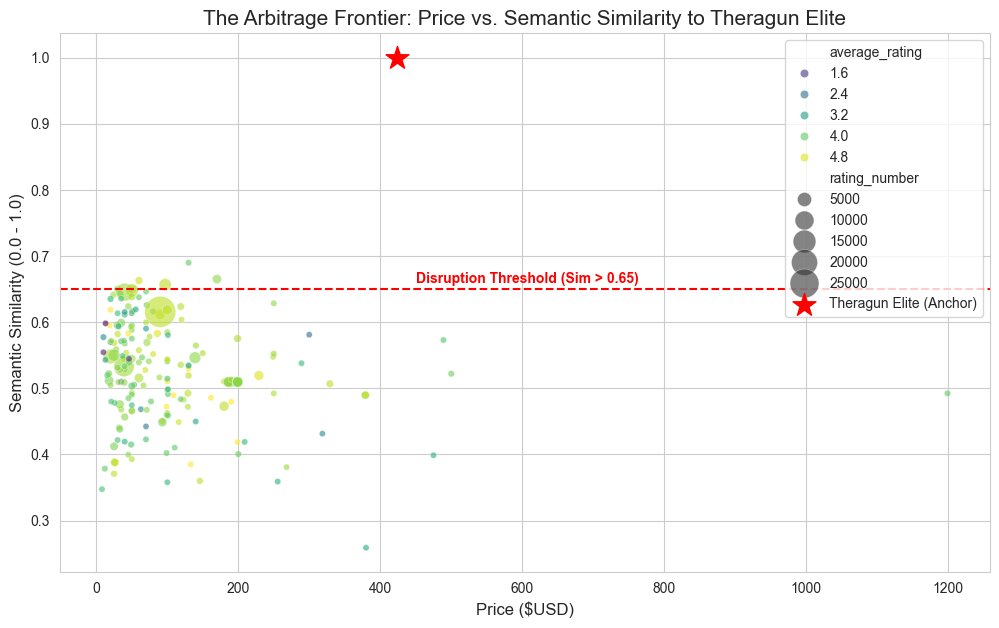

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

# 1. Isolate the Anchor (Theragun Elite)
anchor_title = "TheraGun Elite"
anchor_idx = df_meta[df_meta['title'].str.contains(anchor_title, case=False)].index[0]
anchor_vec = vectors[anchor_idx].reshape(1, -1)

# 2. Calculate similarities for the whole set
df_meta['similarity_to_elite'] = cosine_similarity(anchor_vec, vectors).flatten()

# 3. Create the Visualization
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Plot all products
sns.scatterplot(
    data=df_meta,
    x='price',
    y='similarity_to_elite',
    size='rating_number',
    hue='average_rating',
    palette='viridis',
    sizes=(20, 500),
    alpha=0.6
)

# Highlight the Anchor (The goal we are disrupting)
plt.scatter(
    df_meta.iloc[anchor_idx]['price'],
    df_meta.iloc[anchor_idx]['similarity_to_elite'],
    color='red', s=300, marker='*', label='Theragun Elite (Anchor)'
)

# Label the "Disruption Zone"
plt.axhline(y=0.65, color='r', linestyle='--')
plt.text(450, 0.66, "Disruption Threshold (Sim > 0.65)", color='red', fontweight='bold')

plt.title("The Arbitrage Frontier: Price vs. Semantic Similarity to Theragun Elite", fontsize=15)
plt.xlabel("Price ($USD)", fontsize=12)
plt.ylabel("Semantic Similarity (0.0 - 1.0)", fontsize=12)
plt.legend()
plt.show()

In [55]:
# Check the 1,603 rows for our missing brands
brands_to_find = ['Ekrin', 'Bob and Brad', 'Mighty Bliss', 'Renpho']
brand_patterns = [f"%{b}%" for b in brands_to_find]
# Use the regex but force everything to lowercase for case-insensitivity
search_regex = '|'.join(brands_to_find).lower()

print(f"--- SEARCHING 1,603 ROWS FOR: {search_regex} ---")

missing_audit_query = f"""
SELECT store, title, price, rating_number
FROM hardware
WHERE lower(title) ~ '{search_regex}'
ORDER BY rating_number DESC
LIMIT 20
"""

results = con.execute(missing_audit_query).df()
display(results)

--- SEARCHING 1,603 ROWS FOR: ekrin|bob and brad|mighty bliss|renpho ---


,store,title,price,rating_number
